In [1]:
import pandas as pd
import numpy as np
import dateparser
import matplotlib.pyplot as plt
%matplotlib inline

#Help functions for correcting the 'tld' and 'org' columns
def get_tld(x):
    if type(x) != list:
        return np.nan
    if x[-1] == 'in' and len(x) == 2 and x[-2] in ['ac', 'co']:
        return x[-2] + '.' + 'in'
    else:
        return x[-1]
def get_org(x):
    if type(x) != list:
        return np.nan
    if len(x) == 1:
        return np.nan
    if x[-1] == 'in' and x[-2] in ['ac', 'co'] and len(x) == 3:
        return x[-3]   
    if x[-1] == 'in' and x[-2] in ['ac', 'co'] and len(x) == 2:
        return np.nan   
    return x[-2]

# Data Preprocessing

In [2]:
#load the original data set
df_train = pd.read_csv('train.csv', index_col = 0)
df_test = pd.read_csv('test.csv', index_col = 0)

In [ ]:
#Obtain clean date

#1. There are no missing values in the date column, but several formats exist:
#(a) Sun, 28 Aug 2016 00:17:44 +0000
#(b) 11-MAR-2018 20:40:58
#(c) Mon, 8 Apr 2013 09:59:21
#(d) 25 Apr 2019 07:13:43 -0400
#...
#2. There are also incorrect time zones values, '+0580', which I changed to '0530'

#cleaning training dataset
df_train['date'] = df_train['date'].str.replace(r' \(.*\)', '')
df_train['date'] = df_train['date'].str.rstrip()
df_train['date'] = df_train['date'].str.replace('-0000', '+0000')
df_train['date'] = df_train['date'].str.replace('0580', '0530')
df_train['date'] = df_train['date'].apply(dateparser.parse, languages=['en'])

<ipython-input-3-d7e5bda92627>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['date'] = df_train['date'].str.replace(r' \(.*\)', '')
C:\Users\Vanshika Sharma\anaconda3\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [ ]:
#cleaning test dataset
df_test['date'] = df_test['date'].str.replace(r' \(.*\)', '')
df_test['date'] = df_test['date'].str.rstrip()
df_test['date'] = df_test['date'].str.replace('-0000', '+0000')
df_test['date'] = df_test['date'].str.replace('0580', '0530')
df_test['date'] = df_test['date'].apply(dateparser.parse, languages=['en'])

<ipython-input-6-7f44fbf518b7>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['date'] = df_test['date'].str.replace(r' \(.*\)', '')


In [ ]:
#Train Dataset - Generate year, month, day, day of the week, hour, minute, second and timezone from date
df_train['year'] = df_train['date'].apply(lambda x:x.year)
df_train['month'] = df_train['date'].apply(lambda x:x.month)
df_train['day'] = df_train['date'].apply(lambda x:x.day)
df_train['hour'] = df_train['date'].apply(lambda x:x.hour)
df_train['minute'] = df_train['date'].apply(lambda x:x.minute)
df_train['second'] = df_train['date'].apply(lambda x:x.second)
df_train['weekday'] = df_train['date'].apply(lambda x:x.weekday())
df_train['timezone'] = df_train['date'].apply(lambda x:x.tzname())

In [ ]:
#Test Dataset - Generate year, month, day, day of the week, hour, minute, second and timezone from date
df_test['year'] = df_test['date'].apply(lambda x:x.year)
df_test['month'] = df_test['date'].apply(lambda x:x.month)
df_test['day'] = df_test['date'].apply(lambda x:x.day)
df_test['hour'] = df_test['date'].apply(lambda x:x.hour)
df_test['minute'] = df_test['date'].apply(lambda x:x.minute)
df_test['second'] = df_test['date'].apply(lambda x:x.second)
df_test['weekday'] = df_test['date'].apply(lambda x:x.weekday())
df_test['timezone'] = df_test['date'].apply(lambda x:x.tzname())

In [ ]:
#Merge all the upper case and lower case mailtype calsses by lowering-case the whole column
#e.g. multipart/alternative and Multipart/Alternative
df_train['mail_type'] = df_train['mail_type'].str.lower()
df_test['mail_type'] = df_test['mail_type'].str.lower()

In [8]:
#Save df to train_clean.csv
df_train.to_csv('train_clean.csv')
df_test.to_csv('test_clean.csv')

# Feature Engineering

In [3]:
#load the clean data set
df_train = pd.read_csv('train_clean.csv', index_col = 0)
df_test = pd.read_csv('test_clean.csv', index_col = 0)

In [4]:
#Assumption: if a domain always sends a particular type of emails, then it will always send this type of emails.
#Pairs is a table with such pair of orgs and labels

df_org_label_count = df_train.groupby(['org', 'label']).count().iloc[:,0]
df_org_label_count = df_org_label_count.to_frame().reset_index()
pairs = df_org_label_count[df_org_label_count.groupby('org')['org'].transform(len) == 1]
pairs.columns = ['org', 'label', 'count']
pairs = dict(zip(pairs['org'], pairs['label']))

In [5]:
#Holiday list

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays()
holidays = [x.strftime("%Y-%m-%d") for x in holidays]

In [6]:
pairs

{'0adz': 1,
 '10xrecruit': 1,
 '163': 1,
 '2018': 1,
 '2checkout': 0,
 '3ds': 1,
 '60': 0,
 '86282': 1,
 'HobbyKing': 0,
 'L3Harris': 1,
 'MakeMyTrip': 0,
 'Neo4j': 0,
 'Pennmedicine': 1,
 'aaai': 0,
 'acces-neovote': 0,
 'aciek-academy': 0,
 'acsir': 1,
 'addmi': 0,
 'adh-assurances': 0,
 'adm': 1,
 'adobe': 1,
 'af3': 1,
 'afwerxfusion': 3,
 'agencenavigoannuel': 0,
 'airindia': 0,
 'airtel': 0,
 'alchemyapi': 1,
 'am': 1,
 'amdocs': 1,
 'ameli': 0,
 'andromedapublisher': 1,
 'animalvetsci': 1,
 'aoni': 1,
 'app': 0,
 'arrow': 7,
 'aryaemailer': 2,
 'aspiringmail': 0,
 'awidit': 1,
 'bizee': 3,
 'bluedart': 1,
 'bluelighthost': 1,
 'bpest-dijon': 2,
 'brain': 1,
 'bsnl': 1,
 'buffalo': 2,
 'buyforexonline': 0,
 'cancerimagingarchive': 1,
 'capellaspace': 1,
 'careerfolio': 1,
 'carwale': 0,
 'cdconnect': 2,
 'centrepompidou': 2,
 'ciudad': 1,
 'class': 0,
 'clerky': 0,
 'cloudbees': 2,
 'cloudlinux': 1,
 'cmrjournal': 1,
 'cnvs': 1,
 'com-lpfr': 2,
 'comet-mail': 2,
 'compbuzz': 1,
 

# PCA

In [7]:
df_train.head()

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,...,chars_in_body,label,year,month,day,hour,minute,second,weekday,timezone
0,2017-11-06 11:13:45+01:00,reply,ebay.in,0,0,multipart/alternative,35,120,0,0,...,80027,2,2017,11,6,11,13,45,0,UTC\+01:00
1,2018-02-14 11:00:16+00:00,edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,...,2961,1,2018,2,14,11,0,16,2,UTC\+00:00
2,2016-07-06 19:53:37+00:00,usebackpack,com,0,0,text/html,4,17,0,0,...,25149,1,2016,7,6,19,53,37,2,UTC\+00:00
3,2019-10-11 11:25:40+02:00,granular,ai,0,0,multipart/mixed,0,0,0,0,...,635296,1,2019,10,11,11,25,40,4,UTC\+02:00
4,2017-11-07 11:07:18+00:00,github,com,1,0,multipart/alternative,2,11,0,0,...,2355,1,2017,11,7,11,7,18,1,UTC\+00:00


In [16]:
df_train.drop('date', axis = 1, inplace = True)
df_test.drop('date', axis = 1, inplace = True)

In [9]:
#hot encoding columns
def onehot(df):
    
    # This function will perform one hot coding for org, tld, mail_type, timezone columsn.
    
    one_hot = pd.get_dummies(df[['org', 'tld', 'mail_type', 'timezone']])

    
    # Now we drop the original categorical column to avoid duplicacy. 
    df.drop('org', axis=1, inplace=True)
    df.drop('tld', axis=1, inplace=True)
    df.drop('mail_type', axis=1, inplace=True)
    df.drop('timezone', axis=1, inplace=True)
    
    df = df.join(one_hot)
    return df

In [10]:
onehot(df_train)
onehot(df_test)

,date,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,year,...,timezone_UTC\+07:00,timezone_UTC\+08:00,timezone_UTC\+09:00,timezone_UTC\+10:00,timezone_UTC\+11:00,timezone_UTC\-04:00,timezone_UTC\-05:00,timezone_UTC\-06:00,timezone_UTC\-07:00,timezone_UTC\-08:00
0,2017-11-01 15:51:21+05:30,0,0,0,12,1,0,20.0,4505,2017,...,0,0,0,0,0,0,0,0,0,0
1,2015-03-05 20:47:22-05:00,0,0,7,49,1,0,49.0,32949,2015,...,0,0,0,0,0,0,1,0,0,0
2,2016-04-21 14:53:08+05:30,1,0,0,0,1,0,24.0,1707,2016,...,0,0,0,0,0,0,0,0,0,0
3,2018-02-06 12:12:08+00:00,0,0,13,50,1,0,70.0,76686,2018,...,0,0,0,0,0,0,0,0,0,0
4,2019-05-21 05:56:27-07:00,0,0,18,76,1,0,38.0,22646,2019,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34360,2016-09-19 19:46:53-07:00,0,0,8,110,1,1,134.0,89070,2016,...,0,0,0,0,0,0,0,0,1,0
34361,2016-08-19 06:05:47+00:00,0,0,23,117,1,0,52.0,24241,2016,...,0,0,0,0,0,0,0,0,0,0
34362,2016-05-04 17:06:24+05:30,0,0,1,4,1,0,35.0,4558,2016,...,0,0,0,0,0,0,0,0,0,0
34363,2014-12-29 14:35:52+05:30,0,0,0,6,1,0,38.0,2591,2014,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_test.isnull().sum()

date                0
ccs                 0
bcced               0
images              0
urls                0
salutations         0
designation         0
chars_in_subject    0
chars_in_body       0
year                0
month               0
day                 0
hour                0
minute              0
second              0
weekday             0
dtype: int64

In [12]:
df_train.isnull().sum()

date                0
ccs                 0
bcced               0
images              0
urls                0
salutations         0
designation         0
chars_in_subject    0
chars_in_body       0
label               0
year                0
month               0
day                 0
hour                0
minute              0
second              0
weekday             0
dtype: int64

In [52]:
df_train['chars_in_subject'] = df_train['chars_in_subject'].fillna(0)
df_test['chars_in_subject'] = df_test['chars_in_subject'].fillna(0)

In [13]:
y_train = df_train['label']
df_train.drop('label', axis = 1, inplace = True)

In [17]:
#col_drop=['timezone']
#X_train_ao = train_df_ao.drop(col_drop, axis=1).copy()
#X_test_ao = test_x_ao.drop(col_drop, axis=1).copy()
#y_train = train_df.label

#train_x = train_df[['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       #'salutations', 'designation', 'chars_in_subject', 'chars_in_body',]]
#train_y = train_df[['label']]

#Dimensionality Reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
%matplotlib inline  

pca = PCA(n_components=15)
pca.fit(df_train) 
X_pca = pca.transform(df_train)
X_pca_test = pca.transform(df_test)

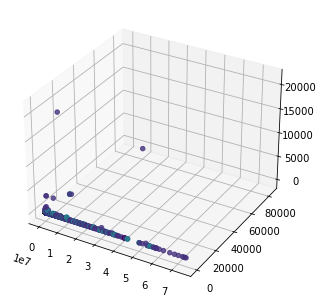

In [18]:
#Filter out outliners
x1 = X_pca[:, 0]
x2 = X_pca[:, 1]
x3 = X_pca[:, 2]

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(x1, x2, x3, c=y_train, alpha=0.8)

In [19]:
#Random Forest Cross Validation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 300)

print(cross_validate(model, X_pca, y_train, cv=5, scoring='f1_macro'))

{'fit_time': array([53.79189706, 52.22890186, 51.63610506, 51.34840059, 52.85443664]), 'score_time': array([1.14265895, 1.06699467, 1.07016134, 1.0412817 , 1.06686878]), 'test_score': array([0.26434087, 0.26986654, 0.27496751, 0.27628512, 0.27764214])}


In [20]:
#Model Training
model.fit(X_pca, y_train)

RandomForestClassifier(n_estimators=300)

In [21]:
#Generate our predictions
y_test = model.predict(X_pca_test).astype(int)
res = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_test})
res.to_csv('submission2_VS_20.11.2021.csv', index=False)

## Random Forest Classifier (without PCA)

In [2]:
import pandas as pd
import numpy as np
import dateparser
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline

In [3]:
#Read train_clean.csv and test_clean.csv
df_train = pd.read_csv('train_clean.csv', index_col = 0)
df_test = pd.read_csv('test_clean.csv', index_col = 0)

In [4]:
df_train['chars_in_subject'] = df_train['chars_in_subject'].fillna(0)
df_test['chars_in_subject'] = df_test['chars_in_subject'].fillna(0)

In [5]:
#Concatenate data together for feature engineering
n = len(df_train)
temp2 = pd.concat([df_train, df_test], axis=0, sort=False).drop(['label'], axis=1)
temp = temp2

#Seperate the 'mail_type' column
temp['mail_type'] = temp['mail_type'].str.strip()
temp['mail_type_1'] = temp['mail_type'].str.split('/',expand=True)[0]
temp['mail_type_2'] = temp['mail_type'].str.split('/',expand=True)[1]
temp = temp.drop('mail_type', axis=1)

#Transform the 'org' and 'tld' columns
temp['org_tld'] = temp['tld'] + '.' + temp['org']
temp['org_tld'] = temp['org_tld'].str.strip()
temp['org_tld'] = temp['org_tld'].str.lower()
temp['org_tld'] = temp['org_tld'].str.split('.')
temp = temp.drop(['org', 'tld'], axis =1)
temp['org_tld'] = temp['org_tld'].fillna('N')

mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(temp['org_tld']),
                   columns=mlb.classes_,
                   index=temp.index)

temp = pd.concat([temp, res], axis=1)
temp = temp.drop('org_tld', axis=1)

#Add numerical labels
catogorical = ['mail_type_1', 'mail_type_2', 'timezone']
temp[catogorical] = temp[catogorical].apply(lambda x: pd.factorize(x)[0])

#Add 'org_freq' and 'tld_freq' columns
for col in catogorical:
    encoding = temp.groupby(col).size()/len(temp)
    temp[col + '_freq'] = temp[col].map(encoding)

#Add the frequency of the 'tld' and 'org'
freq = temp[temp.columns[19:-3]].sum(axis=1)
temp = pd.concat([temp,freq], axis=1)

#Drop apparently non-important features, and date
drop_c = ['bcced', 'designation', 'salutations', 'date', 'mail_type_1_freq', 'mail_type_1']
temp = temp.drop(drop_c, axis=1)

#Drop features that have value 1 for only one row
t1 = temp[:n].sum()
t2 = temp[n:].sum()
temp = temp.drop(set(t2[t2==0].index) | set(t1[t1==0].index), axis=1)

#Drop duplicate columns in the training set
col_non_dup = (temp[:n].T.drop_duplicates().T).columns
temp = temp[col_non_dup]

In [6]:
#Split the data to X, y and X_test

X = temp[:n]
X_test = temp[n:]
y = df_train['label']

In [7]:
#Cross Validation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

#250 & 200 before droppinp duplicate columns
#250 & 175 after droppinp duplicate columns
model = RandomForestClassifier(n_estimators = 250, class_weight='balanced', max_features = 175)

print(cross_validate(model, X, y, cv=5, scoring='f1_macro', return_train_score=True))

{'fit_time': array([138.10836077, 139.68251324, 138.26775575, 138.65143895,
       138.57960939]), 'score_time': array([1.31974244, 1.17857695, 1.17897248, 1.18048716, 1.21642399]), 'test_score': array([0.38062777, 0.40827248, 0.40731703, 0.39852771, 0.38867551]), 'train_score': array([0.76184302, 0.76631504, 0.76010399, 0.76017511, 0.76715849])}


In [ ]:
#Model Training
model.fit(X, y)

In [ ]:
#Generate our predictions
y_test = model.predict(X_test).astype(int)
res = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_test})
res.to_csv('submission.csv', index=False)

## Gradient Boosting

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
#read the csv file
train_df = pd.read_csv('train_clean.csv', index_col=0)
test_df = pd.read_csv('test_clean.csv', index_col=0)

In [3]:
x=train_df.drop(labels=['label','date'],axis=1)
y=train_df['label']
final_x=test_df.drop(labels=['date'],axis=1)

In [4]:
#one hot encoding towards org, tld, mail_type and timezone.And make replacement
x_org=x[['org']]
final_x_org=final_x[['org']]
feat_enc = OneHotEncoder()
feat_enc.fit(np.vstack([x_org, final_x_org]))
x_org_f = feat_enc.transform(x_org)
final_x_org_f = feat_enc.transform(final_x_org)

x_org_f_p=pd.DataFrame(x_org_f.toarray())
final_x_org_f_p=pd.DataFrame(final_x_org_f.toarray())


In [5]:
x_org_f_p=pd.DataFrame(x_org_f.toarray())
final_x_org_f_p=pd.DataFrame(final_x_org_f.toarray())

In [6]:
x_tld=x[['tld']]
final_x_tld=final_x[['tld']]
feat_enc = OneHotEncoder()
feat_enc.fit(np.vstack([x_tld, final_x_tld]))
x_tld_f = feat_enc.transform(x_tld)
final_x_tld_f = feat_enc.transform(final_x_tld)
x_tld_f_p=pd.DataFrame(x_tld_f.toarray())
final_x_tld_f_p=pd.DataFrame(final_x_tld_f.toarray())

In [7]:
x_mail_type=x[['mail_type']]
final_x_mail_type=final_x[['mail_type']]
feat_enc = OneHotEncoder()
feat_enc.fit(np.vstack([x_mail_type, final_x_mail_type]))
x_mail_type_f = feat_enc.transform(x_mail_type)
final_x_mail_type_f = feat_enc.transform(final_x_mail_type)
x_mail_type_f_p=pd.DataFrame(x_mail_type_f.toarray())
final_x_mail_type_f_p=pd.DataFrame(final_x_mail_type_f.toarray())

In [8]:
x=x.drop(labels=['org'],axis=1)
x=pd.concat([x_org_f_p,x],axis=1)
final_x=final_x.drop(labels=['org'],axis=1)
final_x=pd.concat([final_x_org_f_p,final_x],axis=1)

In [9]:
x=x.drop(labels=['tld'],axis=1)
x=pd.concat([x_tld_f_p,x],axis=1)
final_x=final_x.drop(labels=['tld'],axis=1)
final_x=pd.concat([final_x_tld_f_p,final_x],axis=1)

x=x.drop(labels=['mail_type'],axis=1)
x=pd.concat([x_mail_type_f_p,x],axis=1)
final_x=final_x.drop(labels=['mail_type'],axis=1)
final_x=pd.concat([final_x_mail_type_f_p,final_x],axis=1)

In [10]:
x_timezone=x[['timezone']]
final_x_timezone=final_x[['timezone']]
feat_enc = OneHotEncoder()
feat_enc.fit(np.vstack([x_timezone, final_x_timezone]))
x_timezone_f = feat_enc.transform(x_timezone)
final_x_timezone_f = feat_enc.transform(final_x_timezone)
x_timezone_f_p=pd.DataFrame(x_timezone_f.toarray())
final_x_timezone_f_p=pd.DataFrame(final_x_timezone_f.toarray())

x=x.drop(labels=['timezone'],axis=1)
x=pd.concat([x_timezone_f_p,x],axis=1)
final_x=final_x.drop(labels=['timezone'],axis=1)
final_x=pd.concat([final_x_timezone_f_p,final_x],axis=1)

In [11]:
#standarization
x_total=pd.concat([x,final_x])
transformer = StandardScaler().fit(x_total)
x_s = transformer.transform(x)
final_x_s = transformer.transform(final_x)

x_s_p=pd.DataFrame(x_s)
final_x_s_p=pd.DataFrame(final_x_s)


In [12]:
#fill the NaN value to -1
x_s_p=x_s_p.fillna(-1)
final_x_s_p=final_x_s_p.fillna(-1)

In [13]:
#divide the train data in order to test the accuracy before submitting
x_train, x_test, y_train, y_test = train_test_split(x_s_p, y, test_size=0.2)
print (len(x_train), len(x_test))

64140 16036


In [ ]:
#Cross Validation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators = 300)

print(cross_validate(model, x_train, y_train, cv=5, scoring='f1_macro'))

In [15]:

from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier

In [16]:
#Model Training
model = GradientBoostingClassifier(n_estimators = 300)
model.fit(x_train, y_train)

GradientBoostingClassifier(n_estimators=300)

In [17]:
#make prediction
predicted= model.predict(x_test)

In [18]:
#calculate the F1 score. BTW, F1 score has several kinds of average and I guess micro and weighted is closer to the Kaggle system
from sklearn.metrics import f1_score
true = f1_score(predicted, y_test, average='micro')
print(true)

0.5821900723372412


In [ ]:
#make prediction
predict=model.predict(final_x_s_p)

In [ ]:
#save the prediction into csv file
pred_df = pd.DataFrame(predict, columns=['label'])
pred_df.to_csv("GradientBoosting2_submission.csv", index=True, index_label='Id')

## XGBoost

In [19]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [20]:
#read the csv file
train_df = pd.read_csv('train_clean.csv', index_col=0)
test_df = pd.read_csv('test_clean.csv', index_col=0)

In [21]:
x=train_df.drop(labels=['label','date'],axis=1)
y=train_df['label']
final_x=test_df.drop(labels=['date'],axis=1)

In [22]:
#one hot encoding towards org, tld, mail_type and timezone.And make replacement
x_org=x[['org']]
final_x_org=final_x[['org']]
feat_enc = OneHotEncoder()
feat_enc.fit(np.vstack([x_org, final_x_org]))
x_org_f = feat_enc.transform(x_org)
final_x_org_f = feat_enc.transform(final_x_org)

x_org_f_p=pd.DataFrame(x_org_f.toarray())
final_x_org_f_p=pd.DataFrame(final_x_org_f.toarray())

In [23]:
x_org_f_p=pd.DataFrame(x_org_f.toarray())
final_x_org_f_p=pd.DataFrame(final_x_org_f.toarray())

In [24]:
x_tld=x[['tld']]
final_x_tld=final_x[['tld']]
feat_enc = OneHotEncoder()
feat_enc.fit(np.vstack([x_tld, final_x_tld]))
x_tld_f = feat_enc.transform(x_tld)
final_x_tld_f = feat_enc.transform(final_x_tld)
x_tld_f_p=pd.DataFrame(x_tld_f.toarray())
final_x_tld_f_p=pd.DataFrame(final_x_tld_f.toarray())

In [25]:
x_mail_type=x[['mail_type']]
final_x_mail_type=final_x[['mail_type']]
feat_enc = OneHotEncoder()
feat_enc.fit(np.vstack([x_mail_type, final_x_mail_type]))
x_mail_type_f = feat_enc.transform(x_mail_type)
final_x_mail_type_f = feat_enc.transform(final_x_mail_type)
x_mail_type_f_p=pd.DataFrame(x_mail_type_f.toarray())
final_x_mail_type_f_p=pd.DataFrame(final_x_mail_type_f.toarray())

In [26]:
x=x.drop(labels=['org'],axis=1)
x=pd.concat([x_org_f_p,x],axis=1)
final_x=final_x.drop(labels=['org'],axis=1)
final_x=pd.concat([final_x_org_f_p,final_x],axis=1)

In [27]:
x=x.drop(labels=['tld'],axis=1)
x=pd.concat([x_tld_f_p,x],axis=1)
final_x=final_x.drop(labels=['tld'],axis=1)
final_x=pd.concat([final_x_tld_f_p,final_x],axis=1)

x=x.drop(labels=['mail_type'],axis=1)
x=pd.concat([x_mail_type_f_p,x],axis=1)
final_x=final_x.drop(labels=['mail_type'],axis=1)
final_x=pd.concat([final_x_mail_type_f_p,final_x],axis=1)

In [28]:
x_timezone=x[['timezone']]
final_x_timezone=final_x[['timezone']]
feat_enc = OneHotEncoder()
feat_enc.fit(np.vstack([x_timezone, final_x_timezone]))
x_timezone_f = feat_enc.transform(x_timezone)
final_x_timezone_f = feat_enc.transform(final_x_timezone)
x_timezone_f_p=pd.DataFrame(x_timezone_f.toarray())
final_x_timezone_f_p=pd.DataFrame(final_x_timezone_f.toarray())

x=x.drop(labels=['timezone'],axis=1)
x=pd.concat([x_timezone_f_p,x],axis=1)
final_x=final_x.drop(labels=['timezone'],axis=1)
final_x=pd.concat([final_x_timezone_f_p,final_x],axis=1)

In [29]:
#standarization
x_total=pd.concat([x,final_x])
transformer = StandardScaler().fit(x_total)
x_s = transformer.transform(x)
final_x_s = transformer.transform(final_x)

x_s_p=pd.DataFrame(x_s)
final_x_s_p=pd.DataFrame(final_x_s)

In [30]:
#fill the NaN value to -1
x_s_p=x_s_p.fillna(-1)
final_x_s_p=final_x_s_p.fillna(-1)

In [31]:
#divide the train data in order to test the accuracy before submitting
x_train, x_test, y_train, y_test = train_test_split(x_s_p, y, test_size=0.2)
print (len(x_train), len(x_test))

64140 16036


In [32]:
#stary to training the XGBoost model
model = XGBClassifier()
model.fit(x_train, y_train)

D:\Anacoda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [33]:
#make prediction
predicted= model.predict(x_test)

In [34]:
#calculate the F1 score. BTW, F1 score has several kinds of average and I guess micro and weighted is closer to the Kaggle system
from sklearn.metrics import f1_score
true = f1_score(predicted, y_test, average='micro')
print(true)

0.577700174607134


In [ ]:
#make prediction
predict=model.predict(final_x_s_p)

In [ ]:
#save the prediction into csv file
pred_df = pd.DataFrame(predict, columns=['label'])
pred_df.to_csv("XGBoost01_submission.csv", index=True, index_label='Id')

## Neural Network

In [2]:
import pandas as pd
import numpy as np
import dateparser
import matplotlib.pyplot as plt
%matplotlib inline

#Help functions for correcting the 'tld' and 'org' columns
def get_tld(x):
    if type(x) != list:
        return np.nan
    if x[-1] == 'in' and len(x) == 2 and x[-2] in ['ac', 'co']:
        return x[-2] + '.' + 'in'
    else:
        return x[-1]
def get_org(x):
    if type(x) != list:
        return np.nan
    if len(x) == 1:
        return np.nan
    if x[-1] == 'in' and x[-2] in ['ac', 'co'] and len(x) == 3:
        return x[-3]   
    if x[-1] == 'in' and x[-2] in ['ac', 'co'] and len(x) == 2:
        return np.nan   
    return x[-2]

In [3]:
#Read train_clean.csv and test_clean.csv
df_train = pd.read_csv('train_clean.csv', index_col = 0)
df_test = pd.read_csv('test_clean.csv', index_col = 0)

In [4]:
#Concatenate data together for feature engineering

n = len(df_train)
temp = pd.concat([df_train, df_test], axis=0, sort=False).drop(['label'], axis=1)

#Correct the 'org' and 'tld' columns and lowercase them
split_res = temp['tld'].str.split('.')
true_tld = split_res.map(get_tld)
true_org = split_res.map(get_org)
temp['tld'] = true_tld.fillna(temp['tld']).str.lower()
temp['org'] = true_org.fillna(temp['org']).str.lower()

#Take the log of 'chars_in_subject', 'chars_in_body' and 'urls' columns
log = ['chars_in_subject', 'chars_in_body', 'urls']
temp[log] = np.log(temp[log] + 1)

#Add 'org_freq' and 'tld_freq' columns
for col in ['org', 'tld', 'mail_type', 'timezone']:
    encoding = temp.groupby(col).size()/len(temp)
    temp[col + '_freq'] = temp[col].map(encoding)

#Onehot encode data
catogorical = ['org', 'tld', 'mail_type', 'timezone']
temp = pd.concat([temp, pd.get_dummies(temp[catogorical], drop_first=True)], axis=1)
temp = temp.drop(catogorical, axis=1)

#Drop apparently non-important features, and date
temp = temp.drop(['bcced', 'designation', 'salutations', 'date'], axis=1)

In [5]:
#Standarize data
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(temp)
temp = transformer.transform(temp)

#Fill nan with -1
temp = np.nan_to_num(temp, -1)

In [6]:
#Split the data to X, y and X_test
X = temp[:n]
X_test = temp[n:]
y = df_train['label']

In [7]:
#Onehot-encode y
y = pd.get_dummies(y)

In [12]:
#NN
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

n_features = X.shape[1]
input_tensor = Input(shape=(n_features,))
layer1 = Dense(100, activation='relu')(input_tensor)
layer2 = Dense(100, activation='relu')(layer1)
layer3 = Dense(100, activation='relu')(layer2)
output_tensor = Dense(8, activation='sigmoid')(layer3)
model = Model(input_tensor, output_tensor)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
model.fit(X, y, validation_split=0.2, batch_size=16, epochs=100, callbacks=[es])

Epoch 1/100
4009/4009 [==============================] - 3s 689us/step - loss: 0.8434 - accuracy: 0.5438 - val_loss: 0.7834 - val_accuracy: 0.5668
Epoch 2/100
4009/4009 [==============================] - 3s 645us/step - loss: 0.7622 - accuracy: 0.5853 - val_loss: 0.7560 - val_accuracy: 0.5823
Epoch 3/100
4009/4009 [==============================] - 3s 644us/step - loss: 0.7400 - accuracy: 0.5909 - val_loss: 0.7548 - val_accuracy: 0.5824
Epoch 4/100
4009/4009 [==============================] - 3s 649us/step - loss: 0.7269 - accuracy: 0.5987 - val_loss: 0.7380 - val_accuracy: 0.5930
Epoch 5/100
4009/4009 [==============================] - 3s 657us/step - loss: 0.7185 - accuracy: 0.5997 - val_loss: 0.7381 - val_accuracy: 0.5943
Epoch 6/100
4009/4009 [==============================] - 3s 650us/step - loss: 0.7123 - accuracy: 0.6023 - val_loss: 0.7312 - val_accuracy: 0.5970
Epoch 7/100
4009/4009 [==============================] - 3s 659us/step - loss: 0.7048 - accuracy: 0.6035 - val_loss: 0

In [14]:
model.evaluate(X, y)

2506/2506 [==============================] - 1s 429us/step - loss: 0.6862 - accuracy: 0.6157


[0.6862453818321228, 0.6156830191612244]

In [ ]:
y_test = model.predict(X_test).argmax(axis=1)
res = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_test})
res.to_csv('submission-NN.csv', index=False)

## MLP

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [2]:
#read the csv file
train_df = pd.read_csv('train_clean.csv', index_col=0)
test_df = pd.read_csv('test_clean.csv', index_col=0)
x=train_df.drop(labels=['label','date'],axis=1)
y=train_df['label']
final_x=test_df.drop(labels=['date'],axis=1)

In [3]:
#one hot encoding towards org, tld, mail_type and timezone.And make replacement
text_names=['org','tld','mail_type','timezone']
for i in text_names:
    x_i=x[[i]]
    final_x_i=final_x[[i]]
    feat_enc = OneHotEncoder()
    feat_enc.fit(np.vstack([x_i, final_x_i]))
    x_i_f = feat_enc.transform(x_i)
    final_x_i_f = feat_enc.transform(final_x_i)
    x_i_f_p=pd.DataFrame(x_i_f.toarray())
    final_x_i_f_p=pd.DataFrame(final_x_i_f.toarray())
    x=x.drop(labels=[i],axis=1)
    x=pd.concat([x_i_f_p,x],axis=1)
    final_x=final_x.drop(labels=[i],axis=1)
    final_x=pd.concat([final_x_i_f_p,final_x],axis=1)

In [4]:
#fill the NaN value to -1
x=x.fillna(-1)
final_x=final_x.fillna(-1)

In [5]:
#standarization
x_total=pd.concat([x,final_x])
transformer = StandardScaler().fit(x_total)
x_s = transformer.transform(x)
final_x_s = transformer.transform(final_x)

x_s_p=pd.DataFrame(x_s)
final_x_s_p=pd.DataFrame(final_x_s)

In [6]:
#divide the train data in order to test the accuracy before submitting
x_train, x_test, y_train, y_test = train_test_split(x_s_p, y, test_size=0.2)
print (len(x_train), len(x_test))

64140 16036


In [7]:
from sklearn.neural_network import MLPClassifier

In [8]:
mlp=MLPClassifier(solver='adam',activation='relu',hidden_layer_sizes=[10, 10, 5],random_state=1,alpha=0.1).fit(x_train,y_train)
y_pred=mlp.predict(x_test)
MLP_f1=f1_score(y_pred, y_test, average='micro')
print("F1-score:",MLP_f1)

F1-score: 0.5916687453230232


## SVM

In [9]:
from sklearn import svm

In [10]:
SVMmodel = svm.SVC(kernel='rbf', gamma='auto') 
SVMmodel.fit(x_train, y_train)
predicted= SVMmodel.predict(x_test)
true = f1_score(predicted, y_test, average='micro')
print("F1-score:",true)

F1-score: 0.566225991519082


## Extra Tree

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

In [14]:
clf3 = ExtraTreesClassifier(n_estimators=42,max_depth=15,min_samples_split=2,random_state=0)
clf3.fit(x_train,y_train)
y_pred=clf3.predict(x_test)
ET_f1=f1_score(y_pred, y_test, average='micro')
print("F1-score:",ET_f1)

F1-score: 0.508543277625343


## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rfc = RandomForestClassifier(n_estimators=360,max_depth=15,n_jobs=-1,min_samples_leaf=1,min_samples_split=10,random_state=71)
rfc.fit(x_train, y_train)
y_pred=rfc.predict(x_test)
RF_f1=f1_score(y_pred, y_test, average='micro')
print("F1-score:",RF_f1)

F1-score: 0.5419680718383637


## decision tree

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
tree = DecisionTreeClassifier(random_state=3, criterion="entropy", max_depth=11)
tree.fit(x_train,y_train)
y_pred= tree.predict(x_test)
DT_f1=f1_score(y_pred, y_test, average='micro')
print("F1-score:",DT_f1)

F1-score: 0.567223746570217


## NW

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPClassifier
import numpy as np
import _pickle as cPickle
import gzip
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy.ma as ma

In [25]:
dataset = pd.read_csv('train_clean5.csv')
dataset2 = pd.read_csv('test_clean5.csv')

In [26]:
X1 = dataset.iloc[:,2:].values
y1 = dataset.iloc[:,0].values
X = np.where(np.isnan(X1), ma.array(X1, mask=np.isnan(X1)).mean(axis=0), X1)
y = np.where(np.isnan(y1), ma.array(y1, mask=np.isnan(y1)).mean(axis=0), y1)
M1 = dataset2.iloc[:,1:].values
M = np.where(np.isnan(M1), ma.array(M1, mask=np.isnan(M1)).mean(axis=0), M1)
# Splitting the dataset into the Training set and Test set

X_training, X_test_data, y_training, y_test_data = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling

sc_X = StandardScaler()
X = sc_X.fit_transform(X)
sc_M = StandardScaler()
M = sc_M.fit_transform(M)

scorelist = []

mlp = MLPClassifier(activation='relu', hidden_layer_sizes=(30,30,30,30,30,30),learning_rate_init=0.01 ,learning_rate = 'invscaling', max_iter=1000,random_state=3).fit(X_training,y_training)
y_pred= mlp.predict(X_test_data)
NW_f1=f1_score(y_pred, y_test_data, average='micro')
print("F1-score:",NW_f1)

#N = mlp.predict(M)

#n1 = pd.DataFrame(N)
#n1.to_csv('D:\\python\\myproject\\kaggle\\result.csv')
#print(mlp.score(X_test_data, y_test_data))
#print(np.average(np.array(scorelist)))

F1-score: 0.467822399600898


## XGB

In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import dateparser
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import xgboost as xgb

In [2]:
def main():
    # data preprocess
    df_train = pd.read_csv('train.csv', index_col=0)
    df_test = pd.read_csv('test.csv', index_col=0)


    df_train['mail_type'] = df_train['mail_type'].str.lower()
    df_test['mail_type'] = df_test['mail_type'].str.lower()

    df_train.drop('date', axis=1, inplace=True)
    df_test.drop('date', axis=1, inplace=True)

    for col in ['mail_type', 'org', 'tld']:
        encoder_x = LabelEncoder()
        encoder_x.fit(df_train[col])
        df_test[col] = df_test[col].map(lambda s: '<unknown>' if s not in encoder_x.classes_ else s)
        encoder_x.classes_ = np.append(encoder_x.classes_, '<unknown>')

        df_train[col] = encoder_x.transform(df_train[col])
        df_test[col] = encoder_x.transform(df_test[col])

    # train
    X1 = df_train.iloc[:, :11].values
    y1 = df_train.iloc[:, 11].values
    X = np.where(np.isnan(X1), ma.array(X1, mask=np.isnan(X1)).mean(axis=0), X1)
    y = np.where(np.isnan(y1), ma.array(y1, mask=np.isnan(y1)).mean(axis=0), y1)
    X_training, X_test_data, y_training, y_test_data = train_test_split(X, y, test_size=0.2, random_state=0)

    # mlp
    # mlp = MLPClassifier(activation='relu', hidden_layer_sizes=(64, 32, 16))
    # mlp.fit(X_training, y_training)
    # pred = mlp.predict(X_test_data)
    # print(f1_score(y_true=y_test_data, y_pred=pred, average='weighted'))

    # random forest
    rf = RandomForestClassifier(n_estimators=30)
    rf.fit(X_training, y_training)
    pred = rf.predict(X_test_data)
    print(rf.score(X_test_data, y_test_data))
    print(f1_score(y_true=y_test_data, y_pred=pred, average='micro'))

    # xgb
    params = {
        'booster': 'gbtree',
        'objective': 'multi:softmax',
        'num_class': 8,
        'gamma': 0.1,
        'max_depth': 8,
        'lambda': 2,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'min_child_weight': 3,
        'silent': 0,
        'eta': 0.01,
        'seed': 1000,
        'nthread': 4,
    }
    dtrain = xgb.DMatrix(X_training, y_training)
    dtest = xgb.DMatrix(X_test_data, y_test_data)
    num_rounds = 50
    model = xgb.train(params, dtrain, num_rounds)
    pred = model.predict(dtest)

    print(accuracy_score(y_true=y_test_data, y_pred=pred))
    print(f1_score(y_true=y_test_data, y_pred=pred, average='micro'))

    # xgb to reasult
    #X1 = df_test.iloc[:, :11].values
    #X = np.where(np.isnan(X1), ma.array(X1, mask=np.isnan(X1)).mean(axis=0), X1)
    #test = xgb.DMatrix(X)
    #pred = model.predict(test)
    #pred = pred.astype(int)
    #pred_dict = {'score': pred}

    #result = pd.DataFrame(pred_dict)
    #result.to_csv('pred.csv')


if __name__ == '__main__':
    main()

0.44219256672486906
0.44219256672486906
[10:44:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:44:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5710900473933649
0.5710900473933649
